In [102]:
import pandas as pd
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import librosa
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import prince
from prince import FAMD
import scipy.spatial.distance as dist
from collections import defaultdict
from yellowbrick.cluster import KElbowVisualizer
import random
import sklearn

# 2.1 Getting your data 

We want to read the datasets to try to understand which key we can use to merge them together.

First of all we want to fill empty values in the datasets.
The below function take as an input a dataframe and check if in the columns there are any missing values of numeric or string types and fills this value with an empty string, in case of strings, or with a mean of the values of that column in case of numbers.

In [2]:
def filler(dataframe):
    for col in dataframe.columns:
        if dataframe[col].isnull().any():
            if is_string_dtype(dataframe[col]):
                dataframe[col] = dataframe[col].fillna("")
            elif is_numeric_dtype(dataframe[col]):
                dataframe[col] = dataframe[col].fillna(dataframe[col].mean())

In [3]:

tracks = pd.read_csv("tracks.csv")
echonest = pd.read_csv("echonest.csv")
features = pd.read_csv("features.csv")

We take the datasets needed:

In [4]:
tracks_c = tracks.copy()
echonest_c = echonest.copy()
features_c = features.copy()

In [5]:
# First we are gonna fill the datasets using the function filler()
filler(tracks_c)
filler(echonest_c)
filler(features_c)

## 2.2 Choose your features (variables)!

We notice that the number of features is very big (820 columns!) and we want to reduce the number of variables we have to work with.

So let's apply dimensionality reduction!

###  Principal Component Analysis

Principal component analysis, is a statistical technique to convert high dimensional data to low dimensional data by selecting the most important features that capture maximum information about the dataset. The features are selected on the basis of variance that they cause in the output. The feature that causes highest variance is the first principal component. The feature that is responsible for second highest variance is considered the second principal component, and so on. It is important to mention that principal components do not have any correlation with each other.

#### Standardizing the Numeric Features

Since PCA is effected by scale, we need to scale the features in our data before applying PCA. We used StandardScaler to standardize the dataset’s features onto unit scale (mean = 0 and variance = 1) which is a requirement for the optimal performance of algorithms.First we have to chose numeric and categorical columns.

### Echonest 

In [6]:
# First we need to chose numeric and categorical columns 
num_cols = [col for col in echonest_c.columns if echonest_c[col].dtypes != "O"]
cat_cols = [col for col in echonest_c.columns if echonest_c[col].dtypes == "O"]

We decided to reduce the number of temporal features columns from 224 to 32. The reason why we did not choose it lower than this number (32) is to ensure that the total variance is greater than 70%.

In [7]:
filter_temp_col = [col for col in num_cols if col.startswith('temporal')]
#filter_temp_col

In [8]:
# We used PCA for our numerical temporal features columns
x1 = echonest_c.loc[:, filter_temp_col].values
x1 = StandardScaler().fit_transform(x1)

In [9]:
# Initialize the PCA class by passing the number of components to the constructor.
pca = PCA(n_components=32)
# Call the fit and then transform methods by passing the feature set to these methods. 
# The transform method returns the specified number of principal components.
principalComponents = pca.fit_transform(x1)
# Creating Principal data frame
principalDf_1 = pd.DataFrame(data = principalComponents
             , columns = ["principal component Echonest " + str(i) for i in range(1,33)])

In [10]:
#pca.explained_variance_ratio_
print ( "Components = ", pca.n_components_ , ";\nTotal explained variance = ",
      round(pca.explained_variance_ratio_.sum(),5)  )

Components =  32 ;
Total explained variance =  0.71033


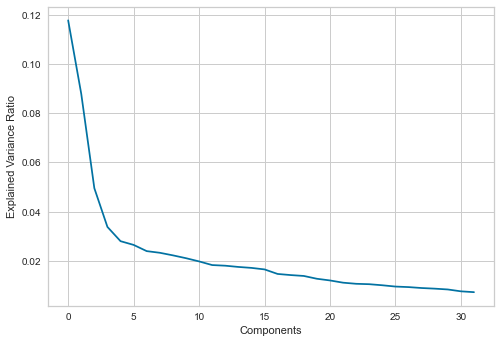

In [11]:
plt.plot(pca.explained_variance_ratio_)
plt.ylabel("Explained Variance Ratio")
plt.xlabel("Components")
plt.show()

We reduced our total column count from 250 to 58. We chose PCA which we know that it works great on continuous data, to do dimensionality reduction on the Temporal Features columns and became sure that the chosen method retains > 70% of the total variance.

In [12]:
other_num_cols = [ele for ele in num_cols if ele not in filter_temp_col]
col_list = cat_cols + other_num_cols
final_echonest = pd.concat([principalDf_1, echonest_c[col_list]], axis = 1)

In [13]:
final_echonest.shape

(13129, 58)

### Tracks

PCA works  on continuous data but our data is a blend of both continuous data and categorical data in this file. Therefore, we searched the other methods. FAMD does the analysis with a combination of PCA and MCA techniques. MCA stands for Multiple Correspondence Analysis which is suitable for multiple categorical factors specifically. If the dataset is grouped by different features with a blend of continuous and categorical values, another technique named MFA (Multiple Factor Analysis) can be deployed.

When we try to apply FAMD, MFA, and MCA for the columns in tracks, we couldn't get any acceptable results. That's why we decided to keep only useful columns in our dataset.

We decide to keep only useful variables:

In [14]:
final_tracks = tracks_c[['track_id', 'album_id', 'artist_id',"artist_location", 'track_bit_rate', 
                    'track_duration', 'track_listens',"track_language_code","track_favorites","track_genre_top",
                     "track_genres","track_genres_all","track_tags","track_title"]]

In [15]:
final_tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   track_id             106574 non-null  int64 
 1   album_id             106574 non-null  int64 
 2   artist_id            106574 non-null  int64 
 3   artist_location      106574 non-null  object
 4   track_bit_rate       106574 non-null  int64 
 5   track_duration       106574 non-null  int64 
 6   track_listens        106574 non-null  int64 
 7   track_language_code  106574 non-null  object
 8   track_favorites      106574 non-null  int64 
 9   track_genre_top      106574 non-null  object
 10  track_genres         106574 non-null  object
 11  track_genres_all     106574 non-null  object
 12  track_tags           106574 non-null  object
 13  track_title          106574 non-null  object
dtypes: int64(7), object(7)
memory usage: 11.4+ MB


In [16]:
final_tracks.shape

(106574, 14)

### Features

First,  we need to analyse our data. We notice that in this file  there is not any categorical variable. \
Then we decided to apply PCA our numerical data. 

We noticed that some column names contain the same word and are closely related. So we filtered the columns containing those words and applied PCA separately. These columns : **Chroma, mfcc, spectral, tonnetz, zcr**

In [17]:
# First we need to chose numeric and categorical columns 
num_cols = [col for col in features_c.columns if features_c[col].dtypes != "O"]
cat_cols = [col for col in features_c.columns if features_c[col].dtypes == "O"]
cat_cols

[]

In [18]:
[col for col in features_c]

['track_id',
 'chroma_cens_kurtosis_01',
 'chroma_cens_kurtosis_02',
 'chroma_cens_kurtosis_03',
 'chroma_cens_kurtosis_04',
 'chroma_cens_kurtosis_05',
 'chroma_cens_kurtosis_06',
 'chroma_cens_kurtosis_07',
 'chroma_cens_kurtosis_08',
 'chroma_cens_kurtosis_09',
 'chroma_cens_kurtosis_10',
 'chroma_cens_kurtosis_11',
 'chroma_cens_kurtosis_12',
 'chroma_cens_max_01',
 'chroma_cens_max_02',
 'chroma_cens_max_03',
 'chroma_cens_max_04',
 'chroma_cens_max_05',
 'chroma_cens_max_06',
 'chroma_cens_max_07',
 'chroma_cens_max_08',
 'chroma_cens_max_09',
 'chroma_cens_max_10',
 'chroma_cens_max_11',
 'chroma_cens_max_12',
 'chroma_cens_mean_01',
 'chroma_cens_mean_02',
 'chroma_cens_mean_03',
 'chroma_cens_mean_04',
 'chroma_cens_mean_05',
 'chroma_cens_mean_06',
 'chroma_cens_mean_07',
 'chroma_cens_mean_08',
 'chroma_cens_mean_09',
 'chroma_cens_mean_10',
 'chroma_cens_mean_11',
 'chroma_cens_mean_12',
 'chroma_cens_median_01',
 'chroma_cens_median_02',
 'chroma_cens_median_03',
 'chroma_

In [19]:
features_c.head()

,track_id,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
1,3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
2,5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
3,10,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
4,20,-0.193837,-0.198527,0.201546,0.258556,0.775204,0.084794,-0.289294,-0.816410,0.043851,...,0.095003,0.022492,0.021355,16.669037,0.469727,0.047225,0.040039,0.000977,3.189831,0.030993


In [20]:
# Filtering the columns which is related to chroma
filter_chroma_col = [col for col in num_cols if col.startswith('chroma')]
len(filter_chroma_col)

252

In [21]:
# We used PCA for our numerical chroma columns
x2 = features_c.loc[:, filter_chroma_col].values
x2 = StandardScaler().fit_transform(x2)

In [22]:
# Initialize the PCA class by passing the number of components to the constructor.
pca2 = PCA(n_components=32)
# Call the fit and then transform methods by passing the feature set to these methods. 
# The transform method returns the specified number of principal components.
principalComponents = pca2.fit_transform(x2)
# Creating Principal data frame
principalDf_2 = pd.DataFrame(data = principalComponents
             , columns = ["principal component F_chroma" + str(i) for i in range(1,33)])

In [23]:
#pca.explained_variance_ratio_
print ( "Components = ", pca2.n_components_ , ";\nTotal explained variance = ",
      round(pca2.explained_variance_ratio_.sum(),5)  )

Components =  32 ;
Total explained variance =  0.77315


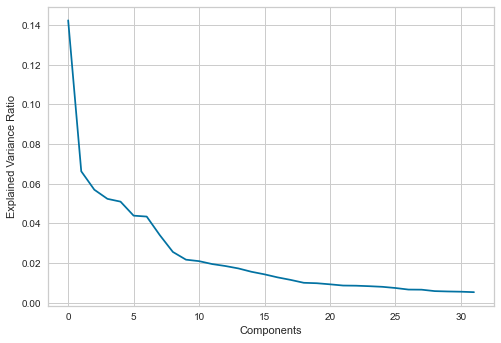

In [24]:
plt.plot(pca2.explained_variance_ratio_)
plt.ylabel("Explained Variance Ratio")
plt.xlabel("Components")
plt.show()

We decided to reduce the number of columns which is related to chroma from 252 to 32. \
The reason why we did not choose it lower than this number (32) is to ensure that the total variance is greater than 70%.

Filtering and PCA to the columns which is related to **mfcc** :

In [25]:
# Filtering the columns which is related to mfcc
filter_mfcc_col = [col for col in num_cols if col.startswith('mfcc')]
len(filter_mfcc_col)

140

In [26]:
# We used PCA for our mfcc columns
x3 = features_c.loc[:, filter_mfcc_col].values
x3 = StandardScaler().fit_transform(x3)

In [27]:
# Initialize the PCA class by passing the number of components to the constructor.
pca3 = PCA(n_components=20)
# Call the fit and then transform methods by passing the feature set to these methods. 
# The transform method returns the specified number of principal components.
principalComponents = pca3.fit_transform(x3)
# Creating Principal data frame
principalDf_3 = pd.DataFrame(data = principalComponents
             , columns = ["principal component F_mfcc " + str(i) for i in range(1,21)])

In [28]:
#pca.explained_variance_ratio_
print ( "Components = ", pca3.n_components_ , ";\nTotal explained variance = ",
      round(pca3.explained_variance_ratio_.sum(),5)  )

Components =  20 ;
Total explained variance =  0.7375


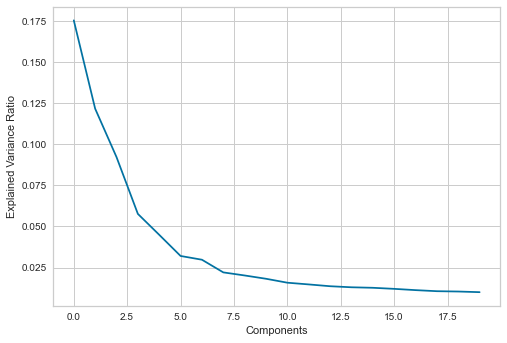

In [29]:
plt.plot(pca3.explained_variance_ratio_)
plt.ylabel("Explained Variance Ratio")
plt.xlabel("Components")
plt.show()

We decided to reduce the number of columns which is related to mfcc from 140 to 21. \
The reason why we did not choose it lower than this number (21) is to ensure that the total variance is greater than 70%.

Filtering and PCA to the columns which is related to **tonnetz** :

In [30]:
# Extracting the columns which is related to tonnetz
filter_tonnetz_col = [col for col in num_cols if col.startswith('tonnetz')]
len(filter_tonnetz_col)

42

In [31]:
# We used PCA for our tonnetz columns
x4 = features_c.loc[:, filter_tonnetz_col].values
x4 = StandardScaler().fit_transform(x4)

In [32]:
# Initialize the PCA class by passing the number of components to the constructor.
pca4 = PCA(n_components=14)
# Call the fit and then transform methods by passing the feature set to these methods. 
# The transform method returns the specified number of principal components.
principalComponents = pca4.fit_transform(x4)
# Creating Principal data frame
principalDf_4 = pd.DataFrame(data = principalComponents
             , columns = ["principal component F_tonnetz " + str(i) for i in range(1,15)])

In [33]:
#pca.explained_variance_ratio_
print ( "Components = ", pca4.n_components_ , ";\nTotal explained variance = ",
      round(pca4.explained_variance_ratio_.sum(),5)  )

Components =  14 ;
Total explained variance =  0.80362


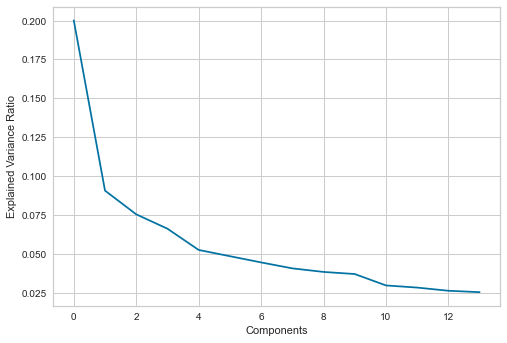

In [34]:
plt.plot(pca4.explained_variance_ratio_)
plt.ylabel("Explained Variance Ratio")
plt.xlabel("Components")
plt.show()

We decided to reduce the number of columns which is related to tonnetz from 42 to 14.
The reason why we did not choose it lower than this number (14) is to ensure that the total variance is greater than 70%.

Filtering and PCA to the columns which is related to **spectral** :

In [35]:
# Extracting the columns which is related to tonnetz
filter_spectral_col = [col for col in num_cols if col.startswith('spectral')]
len(filter_spectral_col)

70

In [36]:
# We used PCA for our spectral columns
x5 = features_c.loc[:, filter_spectral_col].values
x5 = StandardScaler().fit_transform(x5)

In [37]:
# Initialize the PCA class by passing the number of components to the constructor.
pca5 = PCA(n_components=10)
# Call the fit and then transform methods by passing the feature set to these methods. 
# The transform method returns the specified number of principal components.
principalComponents = pca5.fit_transform(x5)
# Creating Principal data frame
principalDf_5 = pd.DataFrame(data = principalComponents
             , columns = ["principal component F_spectral" + str(i) for i in range(1,11)])

In [38]:
#pca.explained_variance_ratio_
print ( "Components = ", pca5.n_components_ , ";\nTotal explained variance = ",
      round(pca5.explained_variance_ratio_.sum(),5))

Components =  10 ;
Total explained variance =  0.70483


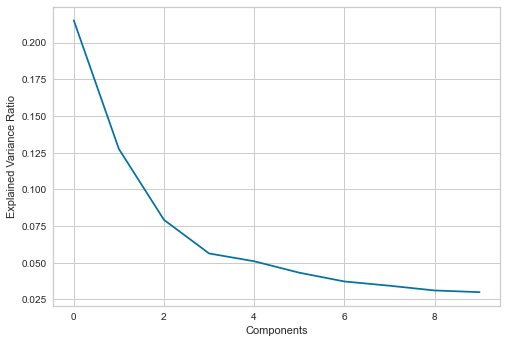

In [39]:
plt.plot(pca5.explained_variance_ratio_)
plt.ylabel("Explained Variance Ratio")
plt.xlabel("Components")
plt.show()

We decided to reduce the number of columns which is related to spectral from 70 to 10. \
The reason why we did not choose it lower than this number (10) is to ensure that the total variance is greater than 70%.

Filtering and PCA to the columns which is related to **zcr** :

In [40]:
# Extracting the columns which is related to zcr
filter_zcr_col = [col for col in num_cols if col.startswith('zcr')]
len(filter_zcr_col)

7

Since we only have 7 columns related to zcr, we decided to keep them without applying PCA.

In [41]:
final_features = pd.concat([principalDf_2,principalDf_3,principalDf_4,principalDf_5, features_c[filter_zcr_col],features_c["track_id"]], axis = 1)

In [42]:
final_features.shape

(106574, 84)

In [43]:
final_features

,principal component F_chroma1,principal component F_chroma2,principal component F_chroma3,principal component F_chroma4,principal component F_chroma5,principal component F_chroma6,principal component F_chroma7,principal component F_chroma8,principal component F_chroma9,principal component F_chroma10,...,principal component F_spectral9,principal component F_spectral10,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01,track_id
0,0.775575,0.363597,1.361552,-3.699527,-6.147775,-5.360350,-1.897574,2.495421,-0.448859,-2.120843,...,-0.189482,-1.422777,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448,2
1,2.396017,-2.216488,-5.514650,-0.510124,1.642146,-3.034904,-3.248686,2.734834,-0.931261,1.087551,...,0.596027,-0.696310,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330,3
2,0.238588,-0.583151,-3.281536,-1.874602,-1.639820,-0.529605,-2.849836,1.959009,-0.717812,0.016183,...,-0.286260,-0.590745,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861,5
3,6.340997,1.307156,-4.068479,-2.896100,1.793508,-2.828160,-2.905913,1.605660,-0.013365,3.209298,...,-0.829564,-0.569972,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800,10
4,-1.902813,-1.745456,-2.876899,2.710234,-0.255222,0.354202,-0.259892,-0.680608,1.648883,3.117666,...,-0.782080,3.433286,16.669037,0.469727,0.047225,0.040039,0.000977,3.189831,0.030993,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106569,1.563060,-1.342387,6.758816,-1.639635,4.023511,2.421905,6.661791,-0.091608,-1.804905,-3.164485,...,1.296953,-0.816901,4.448255,0.172852,0.028773,0.028320,0.003906,0.955388,0.012385,155316
106570,0.976324,-4.937344,2.160017,2.554939,-2.190837,6.301983,-0.158723,1.094531,-0.163944,0.446743,...,1.664312,-0.188437,3.270612,0.196289,0.031116,0.027832,0.002441,1.283060,0.019059,155317
106571,3.719993,-4.143318,2.385720,-1.277057,1.464198,1.783222,3.163254,1.525178,-0.569534,-0.913831,...,1.089796,-0.318234,2.356727,0.212891,0.038450,0.037109,0.003418,0.828569,0.017904,155318
106572,4.565423,-3.903901,0.804845,0.306826,1.538960,-1.027877,0.382104,0.735883,0.115563,0.683806,...,1.494139,-0.607061,6.188604,0.167480,0.041480,0.038086,0.004883,1.818740,0.020133,155319


Once we got all the datasets well filled and standardized, we can start merging them using as key the **track_id** column.

In [44]:
final = final_tracks.merge(final_features.merge(final_echonest, on = "track_id"), on = "track_id")
print(final.shape)
final.head()

(13129, 154)


,track_id,album_id,artist_id,artist_location,track_bit_rate,track_duration,track_listens,track_language_code,track_favorites,track_genre_top,...,ranks_artist_discovery_rank,ranks_artist_familiarity_rank,ranks_artist_hotttnesss_rank,ranks_song_currency_rank,ranks_song_hotttnesss_rank,social_features_artist_discovery,social_features_artist_familiarity,social_features_artist_hotttnesss,social_features_song_currency,social_features_song_hotttnesss
0,2,1,1,New Jersey,256000,168,1293,en,2,Hip-Hop,...,211113.570265,144690.666903,234148.305595,2.919776e+06,2.325537e+06,0.388990,0.386740,0.406370,0.000000,0.000000
1,3,1,1,New Jersey,256000,237,514,en,1,Hip-Hop,...,211113.570265,144690.666903,234148.305595,2.919776e+06,2.325537e+06,0.388990,0.386740,0.406370,0.000000,0.000000
2,5,1,1,New Jersey,256000,206,1151,en,6,Hip-Hop,...,211113.570265,144690.666903,234148.305595,2.919776e+06,2.325537e+06,0.388990,0.386740,0.406370,0.000000,0.000000
3,10,6,6,,192000,161,50135,en,178,Pop,...,2635.000000,2544.000000,397.000000,1.156910e+05,6.760900e+04,0.557339,0.614272,0.798387,0.005158,0.354516
4,134,1,1,New Jersey,256000,207,943,en,3,Hip-Hop,...,211113.570265,144690.666903,234148.305595,2.919776e+06,2.325537e+06,0.388990,0.386740,0.406370,0.000000,0.000000


As we can see, the number of rows is almost 13k, as demanded.

## 2.3 K-Means

By the fact that the k-means algorithm doesn't handle string type objects, I make a copy of the dataset containing only numerical type variables.

In [45]:
final_num = final.select_dtypes(exclude = 'object')
final_num.shape

(13129, 142)

Now I can implement the algorithm which will give me in return the clusters formed.

In [68]:
def kmeans(x,k, no_of_iterations = 100):
    array = np.array(x).reshape(x.shape[0], x.shape[1])
    
    n = array.shape[0]     # Number of rows
    m = array.shape[1]     # Number of columns
    
    # Picking randomly the first centroids
    centroids = array[np.random.choice(n, size = k, replace = False)]
     
    #finding the distance between centroids and all the data points
    distances = dist.cdist(x, centroids ,'euclidean') #Step 2
     
    #Centroid with the minimum Distance
    points = np.array([np.argmin(i) for i in distances]) #Step 3
     
    #Repeating the above steps for a defined number of iterations
    #Step 4
    for _ in range(no_of_iterations): 
        centroids = []
        for idx in range(k):
            #Updating Centroids by taking mean of Cluster it belongs to
            temp_cent = x[points==idx].mean(axis=0)
            elementi = []
            for elem in temp_cent:
                elementi.append(elem)
            centroids.append(elementi)
        centroids = np.vstack(centroids) #Updated Centroids 
        distances = dist.cdist(x,centroids,'euclidean')
        points = np.array([np.argmin(i) for i in distances])
         
    return points, centroids, distances 

In [86]:
p, c, d= kmeans(final_num, 4)

In [87]:
unique, counts = np.unique(p, return_counts=True)
dict(zip(unique, counts))

{0: 631, 1: 11295, 2: 438, 3: 765}

To find an optimal number of clusters we decided to use these 2 different methods:
 - **Elbow Method**
 - **Silhouette Coefficient**

### Elbow Method

Elbow Method is one of the mst famous methods used for the selection of right values of k and for boosting the performance of the model. 

It is used to find the best value of k in this way: it picks up a range of values and takes the best among them by computing the sum of the square of the points ad calculating the average distance.

In the end we will plot a graph of the k-values and examining it we can notice that at some point it will decrease abruptly, that point can be considered the most suitable value of k.

In [71]:
def elbow_method(x, k_min , k_max):
    inertia = []
    K = []
    for k in range(k_min, k_max+1):
        labels, centroids, count  = kmeans(x,k)
        cent = np.array([centroids[i] for i in labels])
        distance = np.linalg.norm(x-cent, axis = 1)
        sum_d = np.sum(distance)
        inertia.append(sum_d)
        K.append(k)
        print(k)
    plt.plot(K, inertia)
    plt.xlabel("K values")
    plt.ylabel("Inertia values")
    plt.show()
    return K, inertia

1
2
3
4
5
6
7
8
9
10


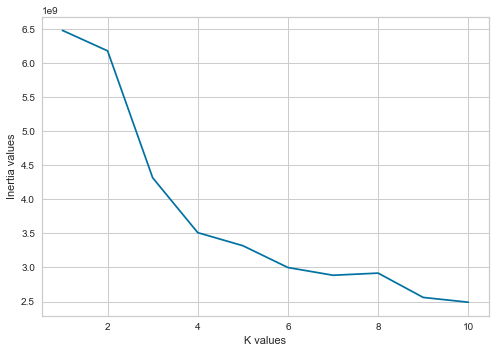

In [72]:
k, inertia = elbow_method(final_num, 1, 10)

As we can see the point of interest are 4 or 6 given that there the graph abruptly decrease.

We now utilize the KMeans version from sklearn to compare the results:

In [78]:
from sklearn.cluster import KMeans
KM = KMeans(n_clusters=4, random_state=0).fit(final_num)
cluster_labels = KM.labels_

In [79]:
unique, counts = np.unique(cluster_labels, return_counts=True)
dict(zip(unique, counts))

{0: 630, 1: 11296, 2: 765, 3: 438}

As we can see the cluster's elements are the same in ours and in the sklearn's k-means algorithm.

The fact that are distributed differently is due to the random choice we did in our algorithm.
Let's now look at the difference in the elbow_method using the sklearn's KMeans:

In [54]:
def elbow_method(x, k_min , k_max):
    inertia = []
    K = []
    for k in range(k_min, k_max+1):
        kmeans =  KMeans(k, random_state=0).fit(final_num)
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_
        cent = np.array([centroids[i] for i in labels])
        distance = np.linalg.norm(x-cent, axis = 1)
        sum_d = np.sum(distance)
        inertia.append(sum_d)
        K.append(k)
        print(k)
    plt.plot(K, inertia)
    plt.xlabel("K values")
    plt.ylabel("Inertia values")
    plt.show()
    return K, inertia

1
2
3
4
5
6
7
8
9
10


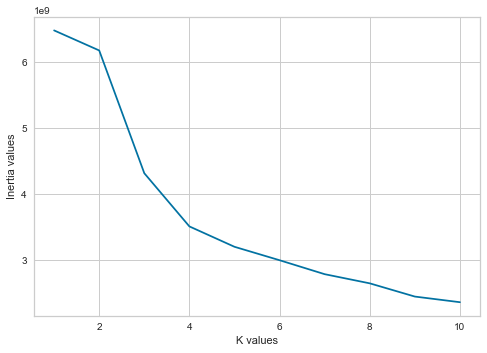

In [55]:
k, inertia = elbow_method(final_num, 1, 10)

Even if the graphs are not exactly identical, we can see the similitude between the two and the elbow point is practically the same.

### Silhouette Score Method

Silhouette Score (or Coefficient) method has the same purpose of the Elbow Method: find the optimal number of clusters.

Its values range between -1 and 1:
- If a value is close to 1 than it means that the clusters will be clearly distinguished.
- Else, if the value is close to -1 than it means that clusters are assigned in the wrong way.

Given a data point $i\in C_I$ (where $C_I$ is a cluster), then the **Silhouette Score** is given by:

$$
    s(i) = \frac{b(i) - a(i)}{max\{a(i),b(i)\}}
$$

Where:
- $a(i)$ is the mean distance between the data point $i$ and all the other data points in the same cluster;
- $b(i)$ is the smallest mean distance between the data point $i$ and all points in any other cluster.

In the end, the **Total Silhouette Coefficient** for a set of exampled is given by the mean of the Silhouette Coefficient for each example.

In [138]:
def silhouette_score(x, labels, centroids):
    cent = np.array([centroids[k] for k in labels])    
    distance = np.linalg.norm(x-cent, axis = 1)
    intra_cluster = np.mean(distance)
    
    temp_near=[]
    for i in range(len(centroids)) : 
        ci = centroids[i]
        for j in range(i+1, len(centroids)) : # avoid to compute the distance twice
            cj = centroids[j]
            if (ci != cj).any() :
                temp_near.append(np.linalg.norm(ci-cj))
    near_cluster = np.mean(np.array(temp_near))
    
    score = (near_cluster - intra_cluster) / max(intra_cluster, near_cluster)
    return score
    

In [139]:
clusters, centroids, count = kmeans(final_num, 10)

In [140]:
silhouette_score(final_num, clusters, centroids)

0.9362103172390124

In [141]:
def silhouette_method(x, k_min, k_max):
    scores = []
    k_values = []
    for k in range(k_min, k_max + 1):
        labels, cetroids, distances  = kmeans(x,k)
        score = silhouette_score(x, labels, centroids)
        scores.append(score)
        k_values.append(k)
        print(k)
    plt.plot(k_values, scores)
    plt.xlabel("K values")
    plt.ylabel("Silhouette Scores")
    plt.show()
    return k_values, scores

1
2
3
4
5
6
7
8
9
10


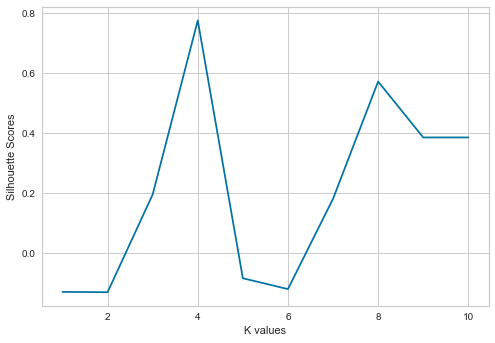

In [135]:
K, silhouette_scores = silhouette_method(final_num, 1, 10)

The Silhouette Coefficient graph indicates that the correct number of cluster to pick is 4, as deduced in the Elbow Method.

Now we will use the already implemented version of K-Means to compare the results obtained from scratch.

We are also using the yellowbrick "KElbowVisualizer" to compare the graph and see the real optimal number of clusters. 

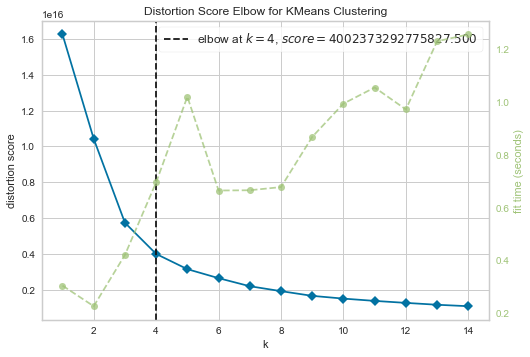

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [137]:
model = KMeans(init='k-means++')
visualizer = KElbowVisualizer(model, k = (1,15), metric = "distortion")
visualizer.fit(final_num)
visualizer.show()

As we can see, the optimal number of clusters here is 4, the exact value of k returned by our methods. 